In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import abc
from collections import defaultdict
import json
from IPython.display import clear_output
from itertools import chain, repeat
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from pathlib import Path
import pickle
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Generator, Optional
import time
import wandb

from dnadb.datasets import Greengenes, Silva
from dnadb import dna, fasta, sample, taxonomy

from deepdna.data.dataset import Dataset
from deepdna.nn.data_generators import SequenceGenerator
from deepdna.nn.models import custom_model, dnabert, load_model, setbert, taxonomy as tax_models
from deepdna.nn.utils import encapsulate_model
from deepdna.nn import layers, functional, utils


In [3]:
tfu.devices.select_gpu(0)

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## Dataset

In [3]:
dataset = Dataset("../../Datasets/synthetic")
tax_db_path = list(dataset.taxonomy_dbs(Dataset.Split.Train))[0]
tax_db = taxonomy.TaxonomyDb(tax_db_path)

fasta_path = next(dataset.fasta_dbs(Dataset.Split.Train))
fasta_mapping_path = fasta_path.with_suffix(".mapping.db")
samples = tuple(sample.load_multiplexed_fasta(fasta_path, fasta_mapping_path))
len(samples)

210

In [4]:
tax_db

In [5]:
sample_tax_pairs = list(zip(samples, repeat(tax_db)))

In [6]:
from deepdna.data.samplers import SampleSampler, SequenceSampler
from deepdna.nn.data_generators import _encode_sequences, BatchGenerator
from typing import Any, cast

class SequenceTaxonomyGenerator(BatchGenerator):
    def __init__(
        self,
        fasta_taxonomy_pairs: Iterable[tuple[sample.FastaSample, taxonomy.TaxonomyDb]],
        sequence_length: int,
        taxonomy_id_map: taxonomy.TaxonomyIdMap,
        kmer: int = 1,
        subsample_size: int|None = None,
        batch_size: int = 32,
        batches_per_epoch: int = 100,
        augment_slide: bool = True,
        augment_ambiguous_bases: bool = True,
        balance: bool = False,
        shuffle: bool = True,
        rng: np.random.Generator = np.random.default_rng()
    ):
        super().__init__(
            batch_size=batch_size,
            batches_per_epoch=batches_per_epoch,
            shuffle=shuffle,
            rng=rng
        )
        fasta_samples, taxonomy_dbs = zip(*fasta_taxonomy_pairs)
        self.sample_sampler = SampleSampler(cast(tuple[sample.FastaSample, ...], fasta_samples))
        self.sequence_sampler = SequenceSampler(sequence_length, augment_slide)
        self.taxonomy_dbs: tuple[taxonomy.TaxonomyDb, ...] = cast(Any, taxonomy_dbs)
        self.kmer = kmer
        self.taxonomy_id_map = taxonomy_id_map
        self.subsample_size = subsample_size
        self.augment_ambiguous_bases = augment_ambiguous_bases
        self.balance = balance

    @property
    def sequence_length(self) -> int:
        return self.sequence_sampler.sequence_length

    def generate_batch(
        self,
        rng: np.random.Generator
    ) -> tuple[npt.NDArray[np.int32], npt.NDArray[np.int32]]:
        subsample_size = self.subsample_size or 1
        sequences = np.empty((self.batch_size, subsample_size), dtype=f"<U{self.sequence_length}")
        sample_ids = np.empty(self.batch_size, dtype=np.int32)
        sequence_ids = [None] * self.batch_size
        label_ids = np.empty((self.batch_size, subsample_size), dtype=np.int32)
        samples = self.sample_sampler.sample_with_ids(self.batch_size, self.balance, rng)
        for i, (sample_id, sample) in enumerate(samples):
            tax_db = self.taxonomy_dbs[sample_id]
            sequence_info = tuple(self.sequence_sampler.sample_with_ids(sample, subsample_size, rng))
            sequence_ids[i], sequences[i] = zip(*sequence_info)
            sample_ids[i] = sample_id
            label_ids[i] = [self.taxonomy_id_map[tax_db.fasta_id_to_label(fasta_id)] for fasta_id in sequence_ids[i]]
        sequences = _encode_sequences(sequences, self.augment_ambiguous_bases, self.rng)
        if self.subsample_size is None:
            sequences = np.squeeze(sequences, axis=1)
        sequences = sequences.astype(np.int32)
        if self.kmer > 1:
            sequences = dna.encode_kmers(sequences, self.kmer, not self.augment_ambiguous_bases).astype(np.int32) # type: ignore
        return sample_ids, sequence_ids, sequences, label_ids

    def reduce_batch(self, batch):
        # remove sample IDs and sequence IDs
        return batch[2:]

## Model

In [8]:
# api = wandb.Api()
run = wandb.init(project="setbert-taxonomy-naive", name="64d-150l", id="nk4v4z4t", resume=True)

wandb: Currently logged in as: sirdavidludwig. Use `wandb login --relogin` to force relogin


In [ ]:
# path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
path = "../../setbert_pretrain"
setbert_model = load_model(path, setbert.SetBertPretrainModel).base

In [10]:
path = "./logs/dnabert_taxonomy_naive"
dnabert_model = load_model(path, tax_models.NaiveHierarchicalTaxonomyClassificationModel)

In [12]:
encoder = setbert.SetBertEncoderModel(setbert_model, compute_sequence_embeddings=True, output_class=False, output_sequences=True, stop_sequence_embedding_gradient=False)
encoder.chunk_size = None
encoder.base.dnabert_encoder.trainable = True
model = tax_models.NaiveTaxonomyClassificationModel(encoder, dnabert_model.taxonomy_id_map)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [13]:
encoder.base.dnabert_encoder.trainable_weights[-1]

<tf.Variable 'relative_transformer_block_7/relative_multi_head_attention_7/attention_output/bias:0' shape=(64,) dtype=float32, numpy=
array([ 0.09145296, -0.02899065, -0.0864097 ,  0.027758  ,  0.01339686,
       -0.00845247,  0.00995629, -0.02662934, -0.03677256, -0.02358089,
       -0.03584136,  0.02725827,  0.01927957, -0.00726849,  0.01948893,
        0.0034098 ,  0.00834959, -0.01392625, -0.00409424, -0.09033129,
        0.034411  ,  0.00326619, -0.01773469, -0.0507396 , -0.06094213,
        0.03672664, -0.074256  ,  0.10130385,  0.02195524,  0.05280458,
       -0.02153208, -0.03432152,  0.01011103,  0.08833213, -0.00949545,
       -0.03538151,  0.03269981, -0.00399983, -0.0952319 ,  0.05764344,
       -0.02990684,  0.02238867,  0.00594427,  0.03579369, -0.03227761,
       -0.00528226,  0.04215879,  0.00757783,  0.00958397,  0.02712066,
        0.02522335,  0.01925748,  0.07012557, -0.00175431,  0.02481306,
       -0.02246495,  0.05090724, -0.01450829,  0.00448123, -0.05487642,
  

In [10]:
model = load_model("logs/models/setbert_taxonomy_naive_full")

In [20]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, 148)]       0         
                                                                 
 set_bert_encoder_model (Set  (None, None, 64)         2340672   
 BertEncoderModel)                                               
                                                                 
 dense_65 (Dense)            (None, None, 11070)       719550    
                                                                 
Total params: 3,060,222
Trainable params: 3,060,222
Non-trainable params: 0
_________________________________________________________________


In [15]:
common_args = dict(
    sequence_length = 150,
    kmer = 3,
    taxonomy_id_map = model.taxonomy_id_map,
    batch_size = 3,
    subsample_size=1,
)

train_data = SequenceTaxonomyGenerator(
    sample_tax_pairs,
    batches_per_epoch=100,
    **common_args)
test_data = SequenceTaxonomyGenerator(
    sample_tax_pairs,
    batches_per_epoch=20,
    shuffle=False,
    **common_args)

In [21]:
model.classify(test_data[0][0])

1/1 [==============================] - 0s 118ms/step


NameError: name 'group' is not defined

In [12]:
wandb_callback = wandb.keras.WandbCallback(save_model=False)
wandb_callback.save_model_as_artifact = False
checkpoint = tf.keras.callbacks.ModelCheckpoint("logs/models/setbert_taxonomy_naive_full", save_best=True)

In [15]:
model.fit(train_data, validation_data=test_data, epochs=550, initial_epoch=450, callbacks=[wandb_callback, checkpoint])

Epoch 451/550
  6/100 [>.............................] - ETA: 2:38 - loss: 0.6357 - sparse_categorical_accuracy: 0.8452WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.8074s vs `on_train_batch_end` time: 0.8810s). Check your callbacks.


100/100 [==============================] - ETA: 0s - loss: 0.6415 - sparse_categorical_accuracy: 0.8437

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.6415 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.5189 - val_sparse_categorical_accuracy: 0.8739
Epoch 452/550
100/100 [==============================] - ETA: 0s - loss: 0.6413 - sparse_categorical_accuracy: 0.8438

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6413 - sparse_categorical_accuracy: 0.8438 - val_loss: 0.5142 - val_sparse_categorical_accuracy: 0.8758
Epoch 453/550
100/100 [==============================] - ETA: 0s - loss: 0.6398 - sparse_categorical_accuracy: 0.8436

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.6398 - sparse_categorical_accuracy: 0.8436 - val_loss: 0.5152 - val_sparse_categorical_accuracy: 0.8759
Epoch 454/550
100/100 [==============================] - ETA: 0s - loss: 0.6382 - sparse_categorical_accuracy: 0.8441

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6382 - sparse_categorical_accuracy: 0.8441 - val_loss: 0.5152 - val_sparse_categorical_accuracy: 0.8757
Epoch 455/550
100/100 [==============================] - ETA: 0s - loss: 0.6391 - sparse_categorical_accuracy: 0.8438

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.6391 - sparse_categorical_accuracy: 0.8438 - val_loss: 0.5162 - val_sparse_categorical_accuracy: 0.8754
Epoch 456/550
100/100 [==============================] - ETA: 0s - loss: 0.6338 - sparse_categorical_accuracy: 0.8448

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6338 - sparse_categorical_accuracy: 0.8448 - val_loss: 0.5085 - val_sparse_categorical_accuracy: 0.8781
Epoch 457/550
100/100 [==============================] - ETA: 0s - loss: 0.6279 - sparse_categorical_accuracy: 0.8467

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6279 - sparse_categorical_accuracy: 0.8467 - val_loss: 0.5133 - val_sparse_categorical_accuracy: 0.8755
Epoch 458/550
100/100 [==============================] - ETA: 0s - loss: 0.6309 - sparse_categorical_accuracy: 0.8466

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6309 - sparse_categorical_accuracy: 0.8466 - val_loss: 0.5116 - val_sparse_categorical_accuracy: 0.8770
Epoch 459/550
100/100 [==============================] - ETA: 0s - loss: 0.6369 - sparse_categorical_accuracy: 0.8447

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6369 - sparse_categorical_accuracy: 0.8447 - val_loss: 0.5121 - val_sparse_categorical_accuracy: 0.8762
Epoch 460/550
100/100 [==============================] - ETA: 0s - loss: 0.6316 - sparse_categorical_accuracy: 0.8457

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6316 - sparse_categorical_accuracy: 0.8457 - val_loss: 0.5093 - val_sparse_categorical_accuracy: 0.8770
Epoch 461/550
100/100 [==============================] - ETA: 0s - loss: 0.6420 - sparse_categorical_accuracy: 0.8422

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6420 - sparse_categorical_accuracy: 0.8422 - val_loss: 0.5104 - val_sparse_categorical_accuracy: 0.8767
Epoch 462/550
100/100 [==============================] - ETA: 0s - loss: 0.6303 - sparse_categorical_accuracy: 0.8459

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6303 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.5141 - val_sparse_categorical_accuracy: 0.8752
Epoch 463/550
100/100 [==============================] - ETA: 0s - loss: 0.6307 - sparse_categorical_accuracy: 0.8454

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.6307 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.5076 - val_sparse_categorical_accuracy: 0.8778
Epoch 464/550
100/100 [==============================] - ETA: 0s - loss: 0.6285 - sparse_categorical_accuracy: 0.8460

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.6285 - sparse_categorical_accuracy: 0.8460 - val_loss: 0.5117 - val_sparse_categorical_accuracy: 0.8768
Epoch 465/550
100/100 [==============================] - ETA: 0s - loss: 0.6198 - sparse_categorical_accuracy: 0.8482

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.6198 - sparse_categorical_accuracy: 0.8482 - val_loss: 0.5103 - val_sparse_categorical_accuracy: 0.8775
Epoch 466/550
100/100 [==============================] - ETA: 0s - loss: 0.6337 - sparse_categorical_accuracy: 0.8454

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6337 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.5108 - val_sparse_categorical_accuracy: 0.8771
Epoch 467/550
100/100 [==============================] - ETA: 0s - loss: 0.6245 - sparse_categorical_accuracy: 0.8464

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.6245 - sparse_categorical_accuracy: 0.8464 - val_loss: 0.5068 - val_sparse_categorical_accuracy: 0.8781
Epoch 468/550
100/100 [==============================] - ETA: 0s - loss: 0.6251 - sparse_categorical_accuracy: 0.8471

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6251 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.5064 - val_sparse_categorical_accuracy: 0.8783
Epoch 469/550
100/100 [==============================] - ETA: 0s - loss: 0.6246 - sparse_categorical_accuracy: 0.8471

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6246 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.5073 - val_sparse_categorical_accuracy: 0.8771
Epoch 470/550
100/100 [==============================] - ETA: 0s - loss: 0.6317 - sparse_categorical_accuracy: 0.8459

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6317 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.5090 - val_sparse_categorical_accuracy: 0.8767
Epoch 471/550
100/100 [==============================] - ETA: 0s - loss: 0.6193 - sparse_categorical_accuracy: 0.8478

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6193 - sparse_categorical_accuracy: 0.8478 - val_loss: 0.5061 - val_sparse_categorical_accuracy: 0.8777
Epoch 472/550
100/100 [==============================] - ETA: 0s - loss: 0.6205 - sparse_categorical_accuracy: 0.8483

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6205 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.5068 - val_sparse_categorical_accuracy: 0.8788
Epoch 473/550
100/100 [==============================] - ETA: 0s - loss: 0.6295 - sparse_categorical_accuracy: 0.8462

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6295 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.5058 - val_sparse_categorical_accuracy: 0.8785
Epoch 474/550
100/100 [==============================] - ETA: 0s - loss: 0.6276 - sparse_categorical_accuracy: 0.8460

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6276 - sparse_categorical_accuracy: 0.8460 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.8783
Epoch 475/550
100/100 [==============================] - ETA: 0s - loss: 0.6251 - sparse_categorical_accuracy: 0.8469

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6251 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.5020 - val_sparse_categorical_accuracy: 0.8782
Epoch 476/550
100/100 [==============================] - ETA: 0s - loss: 0.6340 - sparse_categorical_accuracy: 0.8460

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6340 - sparse_categorical_accuracy: 0.8460 - val_loss: 0.5015 - val_sparse_categorical_accuracy: 0.8790
Epoch 477/550
100/100 [==============================] - ETA: 0s - loss: 0.6250 - sparse_categorical_accuracy: 0.8470

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 249s 2s/step - loss: 0.6250 - sparse_categorical_accuracy: 0.8470 - val_loss: 0.4978 - val_sparse_categorical_accuracy: 0.8787
Epoch 478/550
100/100 [==============================] - ETA: 0s - loss: 0.6305 - sparse_categorical_accuracy: 0.8468

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6305 - sparse_categorical_accuracy: 0.8468 - val_loss: 0.5024 - val_sparse_categorical_accuracy: 0.8789
Epoch 479/550
100/100 [==============================] - ETA: 0s - loss: 0.6233 - sparse_categorical_accuracy: 0.8473

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6233 - sparse_categorical_accuracy: 0.8473 - val_loss: 0.5064 - val_sparse_categorical_accuracy: 0.8774
Epoch 480/550
100/100 [==============================] - ETA: 0s - loss: 0.6221 - sparse_categorical_accuracy: 0.8470

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6221 - sparse_categorical_accuracy: 0.8470 - val_loss: 0.5061 - val_sparse_categorical_accuracy: 0.8775
Epoch 481/550
100/100 [==============================] - ETA: 0s - loss: 0.6232 - sparse_categorical_accuracy: 0.8483

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6232 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.5004 - val_sparse_categorical_accuracy: 0.8791
Epoch 482/550
100/100 [==============================] - ETA: 0s - loss: 0.6269 - sparse_categorical_accuracy: 0.8461

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6269 - sparse_categorical_accuracy: 0.8461 - val_loss: 0.5023 - val_sparse_categorical_accuracy: 0.8788
Epoch 483/550
100/100 [==============================] - ETA: 0s - loss: 0.6252 - sparse_categorical_accuracy: 0.8467

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6252 - sparse_categorical_accuracy: 0.8467 - val_loss: 0.5023 - val_sparse_categorical_accuracy: 0.8797
Epoch 484/550
100/100 [==============================] - ETA: 0s - loss: 0.6196 - sparse_categorical_accuracy: 0.8483

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6196 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.5009 - val_sparse_categorical_accuracy: 0.8792
Epoch 485/550
100/100 [==============================] - ETA: 0s - loss: 0.6272 - sparse_categorical_accuracy: 0.8476

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6272 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.4997 - val_sparse_categorical_accuracy: 0.8792
Epoch 486/550
100/100 [==============================] - ETA: 0s - loss: 0.6192 - sparse_categorical_accuracy: 0.8484

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6192 - sparse_categorical_accuracy: 0.8484 - val_loss: 0.5021 - val_sparse_categorical_accuracy: 0.8795
Epoch 487/550
100/100 [==============================] - ETA: 0s - loss: 0.6242 - sparse_categorical_accuracy: 0.8478

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6242 - sparse_categorical_accuracy: 0.8478 - val_loss: 0.5011 - val_sparse_categorical_accuracy: 0.8785
Epoch 488/550
100/100 [==============================] - ETA: 0s - loss: 0.6208 - sparse_categorical_accuracy: 0.8476

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6208 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.4990 - val_sparse_categorical_accuracy: 0.8785
Epoch 489/550
100/100 [==============================] - ETA: 0s - loss: 0.6149 - sparse_categorical_accuracy: 0.8490

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6149 - sparse_categorical_accuracy: 0.8490 - val_loss: 0.5028 - val_sparse_categorical_accuracy: 0.8787
Epoch 490/550
100/100 [==============================] - ETA: 0s - loss: 0.6159 - sparse_categorical_accuracy: 0.8490

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6159 - sparse_categorical_accuracy: 0.8490 - val_loss: 0.5009 - val_sparse_categorical_accuracy: 0.8790
Epoch 491/550
100/100 [==============================] - ETA: 0s - loss: 0.6149 - sparse_categorical_accuracy: 0.8483

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6149 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.4999 - val_sparse_categorical_accuracy: 0.8788
Epoch 492/550
100/100 [==============================] - ETA: 0s - loss: 0.6172 - sparse_categorical_accuracy: 0.8497

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6172 - sparse_categorical_accuracy: 0.8497 - val_loss: 0.5002 - val_sparse_categorical_accuracy: 0.8790
Epoch 493/550
100/100 [==============================] - ETA: 0s - loss: 0.6173 - sparse_categorical_accuracy: 0.8496

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6173 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.4953 - val_sparse_categorical_accuracy: 0.8808
Epoch 494/550
100/100 [==============================] - ETA: 0s - loss: 0.6093 - sparse_categorical_accuracy: 0.8506

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6093 - sparse_categorical_accuracy: 0.8506 - val_loss: 0.4973 - val_sparse_categorical_accuracy: 0.8798
Epoch 495/550
100/100 [==============================] - ETA: 0s - loss: 0.6154 - sparse_categorical_accuracy: 0.8490

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6154 - sparse_categorical_accuracy: 0.8490 - val_loss: 0.5006 - val_sparse_categorical_accuracy: 0.8788
Epoch 496/550
100/100 [==============================] - ETA: 0s - loss: 0.6141 - sparse_categorical_accuracy: 0.8498

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6141 - sparse_categorical_accuracy: 0.8498 - val_loss: 0.4941 - val_sparse_categorical_accuracy: 0.8809
Epoch 497/550
100/100 [==============================] - ETA: 0s - loss: 0.6255 - sparse_categorical_accuracy: 0.8479

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6255 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.4997 - val_sparse_categorical_accuracy: 0.8786
Epoch 498/550
100/100 [==============================] - ETA: 0s - loss: 0.6135 - sparse_categorical_accuracy: 0.8503

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6135 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.5003 - val_sparse_categorical_accuracy: 0.8798
Epoch 499/550
100/100 [==============================] - ETA: 0s - loss: 0.6092 - sparse_categorical_accuracy: 0.8508

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6092 - sparse_categorical_accuracy: 0.8508 - val_loss: 0.4968 - val_sparse_categorical_accuracy: 0.8792
Epoch 500/550
100/100 [==============================] - ETA: 0s - loss: 0.6133 - sparse_categorical_accuracy: 0.8501

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6133 - sparse_categorical_accuracy: 0.8501 - val_loss: 0.4940 - val_sparse_categorical_accuracy: 0.8812
Epoch 501/550
100/100 [==============================] - ETA: 0s - loss: 0.6119 - sparse_categorical_accuracy: 0.8508

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6119 - sparse_categorical_accuracy: 0.8508 - val_loss: 0.4975 - val_sparse_categorical_accuracy: 0.8795
Epoch 502/550
100/100 [==============================] - ETA: 0s - loss: 0.6153 - sparse_categorical_accuracy: 0.8500

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6153 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4979 - val_sparse_categorical_accuracy: 0.8796
Epoch 503/550
100/100 [==============================] - ETA: 0s - loss: 0.6009 - sparse_categorical_accuracy: 0.8532

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.6009 - sparse_categorical_accuracy: 0.8532 - val_loss: 0.4966 - val_sparse_categorical_accuracy: 0.8796
Epoch 504/550
100/100 [==============================] - ETA: 0s - loss: 0.6101 - sparse_categorical_accuracy: 0.8516

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6101 - sparse_categorical_accuracy: 0.8516 - val_loss: 0.4903 - val_sparse_categorical_accuracy: 0.8813
Epoch 505/550
100/100 [==============================] - ETA: 0s - loss: 0.6061 - sparse_categorical_accuracy: 0.8518

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6061 - sparse_categorical_accuracy: 0.8518 - val_loss: 0.4910 - val_sparse_categorical_accuracy: 0.8814
Epoch 506/550
100/100 [==============================] - ETA: 0s - loss: 0.6187 - sparse_categorical_accuracy: 0.8494

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6187 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.4911 - val_sparse_categorical_accuracy: 0.8802
Epoch 507/550
100/100 [==============================] - ETA: 0s - loss: 0.6114 - sparse_categorical_accuracy: 0.8504

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.6114 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.4890 - val_sparse_categorical_accuracy: 0.8821
Epoch 508/550
100/100 [==============================] - ETA: 0s - loss: 0.6105 - sparse_categorical_accuracy: 0.8505

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.6105 - sparse_categorical_accuracy: 0.8505 - val_loss: 0.4898 - val_sparse_categorical_accuracy: 0.8817
Epoch 509/550
100/100 [==============================] - ETA: 0s - loss: 0.6050 - sparse_categorical_accuracy: 0.8522

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 306s 3s/step - loss: 0.6050 - sparse_categorical_accuracy: 0.8522 - val_loss: 0.4878 - val_sparse_categorical_accuracy: 0.8818
Epoch 510/550
100/100 [==============================] - ETA: 0s - loss: 0.6097 - sparse_categorical_accuracy: 0.8502

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6097 - sparse_categorical_accuracy: 0.8502 - val_loss: 0.4912 - val_sparse_categorical_accuracy: 0.8807
Epoch 511/550
100/100 [==============================] - ETA: 0s - loss: 0.6160 - sparse_categorical_accuracy: 0.8487

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6160 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.4919 - val_sparse_categorical_accuracy: 0.8812
Epoch 512/550
100/100 [==============================] - ETA: 0s - loss: 0.6046 - sparse_categorical_accuracy: 0.8511

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6046 - sparse_categorical_accuracy: 0.8511 - val_loss: 0.4923 - val_sparse_categorical_accuracy: 0.8809
Epoch 513/550
100/100 [==============================] - ETA: 0s - loss: 0.6096 - sparse_categorical_accuracy: 0.8505

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6096 - sparse_categorical_accuracy: 0.8505 - val_loss: 0.4878 - val_sparse_categorical_accuracy: 0.8824
Epoch 514/550
100/100 [==============================] - ETA: 0s - loss: 0.6090 - sparse_categorical_accuracy: 0.8513

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6090 - sparse_categorical_accuracy: 0.8513 - val_loss: 0.4872 - val_sparse_categorical_accuracy: 0.8817
Epoch 515/550
100/100 [==============================] - ETA: 0s - loss: 0.6146 - sparse_categorical_accuracy: 0.8486

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 249s 3s/step - loss: 0.6146 - sparse_categorical_accuracy: 0.8486 - val_loss: 0.4905 - val_sparse_categorical_accuracy: 0.8806
Epoch 516/550
100/100 [==============================] - ETA: 0s - loss: 0.6030 - sparse_categorical_accuracy: 0.8522

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.6030 - sparse_categorical_accuracy: 0.8522 - val_loss: 0.4879 - val_sparse_categorical_accuracy: 0.8820
Epoch 517/550
100/100 [==============================] - ETA: 0s - loss: 0.6028 - sparse_categorical_accuracy: 0.8520

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6028 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.4867 - val_sparse_categorical_accuracy: 0.8830
Epoch 518/550
100/100 [==============================] - ETA: 0s - loss: 0.6075 - sparse_categorical_accuracy: 0.8514

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6075 - sparse_categorical_accuracy: 0.8514 - val_loss: 0.4845 - val_sparse_categorical_accuracy: 0.8824
Epoch 519/550
100/100 [==============================] - ETA: 0s - loss: 0.6064 - sparse_categorical_accuracy: 0.8519

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6064 - sparse_categorical_accuracy: 0.8519 - val_loss: 0.4834 - val_sparse_categorical_accuracy: 0.8830
Epoch 520/550
100/100 [==============================] - ETA: 0s - loss: 0.6062 - sparse_categorical_accuracy: 0.8516

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6062 - sparse_categorical_accuracy: 0.8516 - val_loss: 0.4848 - val_sparse_categorical_accuracy: 0.8821
Epoch 521/550
100/100 [==============================] - ETA: 0s - loss: 0.6073 - sparse_categorical_accuracy: 0.8512

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 248s 2s/step - loss: 0.6073 - sparse_categorical_accuracy: 0.8512 - val_loss: 0.4836 - val_sparse_categorical_accuracy: 0.8832
Epoch 522/550
100/100 [==============================] - ETA: 0s - loss: 0.6048 - sparse_categorical_accuracy: 0.8529

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6048 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.4816 - val_sparse_categorical_accuracy: 0.8836
Epoch 523/550
100/100 [==============================] - ETA: 0s - loss: 0.6033 - sparse_categorical_accuracy: 0.8523

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6033 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.4881 - val_sparse_categorical_accuracy: 0.8815
Epoch 524/550
100/100 [==============================] - ETA: 0s - loss: 0.6112 - sparse_categorical_accuracy: 0.8512

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 257s 3s/step - loss: 0.6112 - sparse_categorical_accuracy: 0.8512 - val_loss: 0.4880 - val_sparse_categorical_accuracy: 0.8823
Epoch 525/550
100/100 [==============================] - ETA: 0s - loss: 0.5981 - sparse_categorical_accuracy: 0.8534

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5981 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.4809 - val_sparse_categorical_accuracy: 0.8841
Epoch 526/550
100/100 [==============================] - ETA: 0s - loss: 0.6060 - sparse_categorical_accuracy: 0.8522

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.6060 - sparse_categorical_accuracy: 0.8522 - val_loss: 0.4845 - val_sparse_categorical_accuracy: 0.8823
Epoch 527/550
100/100 [==============================] - ETA: 0s - loss: 0.6002 - sparse_categorical_accuracy: 0.8527

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6002 - sparse_categorical_accuracy: 0.8527 - val_loss: 0.4858 - val_sparse_categorical_accuracy: 0.8816
Epoch 528/550
100/100 [==============================] - ETA: 0s - loss: 0.5993 - sparse_categorical_accuracy: 0.8529

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5993 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.4840 - val_sparse_categorical_accuracy: 0.8831
Epoch 529/550
100/100 [==============================] - ETA: 0s - loss: 0.6093 - sparse_categorical_accuracy: 0.8507

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.6093 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.4890 - val_sparse_categorical_accuracy: 0.8814
Epoch 530/550
100/100 [==============================] - ETA: 0s - loss: 0.6031 - sparse_categorical_accuracy: 0.8523

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.6031 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.4825 - val_sparse_categorical_accuracy: 0.8825
Epoch 531/550
100/100 [==============================] - ETA: 0s - loss: 0.6032 - sparse_categorical_accuracy: 0.8526

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.6032 - sparse_categorical_accuracy: 0.8526 - val_loss: 0.4862 - val_sparse_categorical_accuracy: 0.8821
Epoch 532/550
100/100 [==============================] - ETA: 0s - loss: 0.5978 - sparse_categorical_accuracy: 0.8532

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5978 - sparse_categorical_accuracy: 0.8532 - val_loss: 0.4846 - val_sparse_categorical_accuracy: 0.8831
Epoch 533/550
100/100 [==============================] - ETA: 0s - loss: 0.6007 - sparse_categorical_accuracy: 0.8530

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.6007 - sparse_categorical_accuracy: 0.8530 - val_loss: 0.4815 - val_sparse_categorical_accuracy: 0.8830
Epoch 534/550
100/100 [==============================] - ETA: 0s - loss: 0.5950 - sparse_categorical_accuracy: 0.8536

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5950 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.4798 - val_sparse_categorical_accuracy: 0.8840
Epoch 535/550
100/100 [==============================] - ETA: 0s - loss: 0.5998 - sparse_categorical_accuracy: 0.8536

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.5998 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.4815 - val_sparse_categorical_accuracy: 0.8834
Epoch 536/550
100/100 [==============================] - ETA: 0s - loss: 0.5996 - sparse_categorical_accuracy: 0.8536

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 254s 3s/step - loss: 0.5996 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.4814 - val_sparse_categorical_accuracy: 0.8838
Epoch 537/550
100/100 [==============================] - ETA: 0s - loss: 0.5970 - sparse_categorical_accuracy: 0.8530

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.5970 - sparse_categorical_accuracy: 0.8530 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.8834
Epoch 538/550
100/100 [==============================] - ETA: 0s - loss: 0.5967 - sparse_categorical_accuracy: 0.8549

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5967 - sparse_categorical_accuracy: 0.8549 - val_loss: 0.4809 - val_sparse_categorical_accuracy: 0.8828
Epoch 539/550
100/100 [==============================] - ETA: 0s - loss: 0.5883 - sparse_categorical_accuracy: 0.8559

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5883 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.4792 - val_sparse_categorical_accuracy: 0.8839
Epoch 540/550
100/100 [==============================] - ETA: 0s - loss: 0.5993 - sparse_categorical_accuracy: 0.8521

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5993 - sparse_categorical_accuracy: 0.8521 - val_loss: 0.4775 - val_sparse_categorical_accuracy: 0.8844
Epoch 541/550
100/100 [==============================] - ETA: 0s - loss: 0.5960 - sparse_categorical_accuracy: 0.8545

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5960 - sparse_categorical_accuracy: 0.8545 - val_loss: 0.4790 - val_sparse_categorical_accuracy: 0.8842
Epoch 542/550
100/100 [==============================] - ETA: 0s - loss: 0.5944 - sparse_categorical_accuracy: 0.8546

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5944 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.4778 - val_sparse_categorical_accuracy: 0.8842
Epoch 543/550
100/100 [==============================] - ETA: 0s - loss: 0.5977 - sparse_categorical_accuracy: 0.8531

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 249s 2s/step - loss: 0.5977 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.4833 - val_sparse_categorical_accuracy: 0.8834
Epoch 544/550
100/100 [==============================] - ETA: 0s - loss: 0.6012 - sparse_categorical_accuracy: 0.8526

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.6012 - sparse_categorical_accuracy: 0.8526 - val_loss: 0.4770 - val_sparse_categorical_accuracy: 0.8838
Epoch 545/550
100/100 [==============================] - ETA: 0s - loss: 0.5944 - sparse_categorical_accuracy: 0.8546

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 249s 2s/step - loss: 0.5944 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.4744 - val_sparse_categorical_accuracy: 0.8855
Epoch 546/550
100/100 [==============================] - ETA: 0s - loss: 0.5898 - sparse_categorical_accuracy: 0.8562

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5898 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.4764 - val_sparse_categorical_accuracy: 0.8852
Epoch 547/550
100/100 [==============================] - ETA: 0s - loss: 0.5867 - sparse_categorical_accuracy: 0.8562

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5867 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.4761 - val_sparse_categorical_accuracy: 0.8849
Epoch 548/550
100/100 [==============================] - ETA: 0s - loss: 0.5941 - sparse_categorical_accuracy: 0.8545

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5941 - sparse_categorical_accuracy: 0.8545 - val_loss: 0.4765 - val_sparse_categorical_accuracy: 0.8857
Epoch 549/550
100/100 [==============================] - ETA: 0s - loss: 0.5959 - sparse_categorical_accuracy: 0.8540

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5959 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.4773 - val_sparse_categorical_accuracy: 0.8848
Epoch 550/550
100/100 [==============================] - ETA: 0s - loss: 0.5992 - sparse_categorical_accuracy: 0.8536

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5992 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.4781 - val_sparse_categorical_accuracy: 0.8831


In [16]:
model.fit(train_data, validation_data=test_data, epochs=700, initial_epoch=550, callbacks=[wandb_callback, checkpoint])

Epoch 551/700
  6/100 [>.............................] - ETA: 2:39 - loss: 0.6152 - sparse_categorical_accuracy: 0.8526WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.8101s vs `on_train_batch_end` time: 0.8820s). Check your callbacks.


100/100 [==============================] - ETA: 0s - loss: 0.5917 - sparse_categorical_accuracy: 0.8550

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5917 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.4760 - val_sparse_categorical_accuracy: 0.8851
Epoch 552/700
100/100 [==============================] - ETA: 0s - loss: 0.5896 - sparse_categorical_accuracy: 0.8555

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5896 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.4765 - val_sparse_categorical_accuracy: 0.8842
Epoch 553/700
100/100 [==============================] - ETA: 0s - loss: 0.5919 - sparse_categorical_accuracy: 0.8552

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5919 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.4740 - val_sparse_categorical_accuracy: 0.8855
Epoch 554/700
100/100 [==============================] - ETA: 0s - loss: 0.5955 - sparse_categorical_accuracy: 0.8548

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5955 - sparse_categorical_accuracy: 0.8548 - val_loss: 0.4720 - val_sparse_categorical_accuracy: 0.8852
Epoch 555/700
100/100 [==============================] - ETA: 0s - loss: 0.5905 - sparse_categorical_accuracy: 0.8555

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5905 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.4740 - val_sparse_categorical_accuracy: 0.8849
Epoch 556/700
100/100 [==============================] - ETA: 0s - loss: 0.5906 - sparse_categorical_accuracy: 0.8547

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5906 - sparse_categorical_accuracy: 0.8547 - val_loss: 0.4718 - val_sparse_categorical_accuracy: 0.8863
Epoch 557/700
100/100 [==============================] - ETA: 0s - loss: 0.5948 - sparse_categorical_accuracy: 0.8549

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 244s 2s/step - loss: 0.5948 - sparse_categorical_accuracy: 0.8549 - val_loss: 0.4735 - val_sparse_categorical_accuracy: 0.8843
Epoch 558/700
100/100 [==============================] - ETA: 0s - loss: 0.5889 - sparse_categorical_accuracy: 0.8558

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5889 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.4752 - val_sparse_categorical_accuracy: 0.8843
Epoch 559/700
100/100 [==============================] - ETA: 0s - loss: 0.5934 - sparse_categorical_accuracy: 0.8550

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5934 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.4756 - val_sparse_categorical_accuracy: 0.8839
Epoch 560/700
100/100 [==============================] - ETA: 0s - loss: 0.5942 - sparse_categorical_accuracy: 0.8542

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5942 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.4722 - val_sparse_categorical_accuracy: 0.8847
Epoch 561/700
100/100 [==============================] - ETA: 0s - loss: 0.5879 - sparse_categorical_accuracy: 0.8558

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5879 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.4765 - val_sparse_categorical_accuracy: 0.8844
Epoch 562/700
100/100 [==============================] - ETA: 0s - loss: 0.5873 - sparse_categorical_accuracy: 0.8552

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5873 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.4703 - val_sparse_categorical_accuracy: 0.8858
Epoch 563/700
100/100 [==============================] - ETA: 0s - loss: 0.5845 - sparse_categorical_accuracy: 0.8570

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5845 - sparse_categorical_accuracy: 0.8570 - val_loss: 0.4704 - val_sparse_categorical_accuracy: 0.8855
Epoch 564/700
100/100 [==============================] - ETA: 0s - loss: 0.5916 - sparse_categorical_accuracy: 0.8558

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5916 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.4699 - val_sparse_categorical_accuracy: 0.8858
Epoch 565/700
100/100 [==============================] - ETA: 0s - loss: 0.5893 - sparse_categorical_accuracy: 0.8553

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5893 - sparse_categorical_accuracy: 0.8553 - val_loss: 0.4707 - val_sparse_categorical_accuracy: 0.8856
Epoch 566/700
100/100 [==============================] - ETA: 0s - loss: 0.5868 - sparse_categorical_accuracy: 0.8560

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5868 - sparse_categorical_accuracy: 0.8560 - val_loss: 0.4704 - val_sparse_categorical_accuracy: 0.8851
Epoch 567/700
100/100 [==============================] - ETA: 0s - loss: 0.5880 - sparse_categorical_accuracy: 0.8555

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 306s 3s/step - loss: 0.5880 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.4692 - val_sparse_categorical_accuracy: 0.8859
Epoch 568/700
100/100 [==============================] - ETA: 0s - loss: 0.5825 - sparse_categorical_accuracy: 0.8566

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5825 - sparse_categorical_accuracy: 0.8566 - val_loss: 0.4715 - val_sparse_categorical_accuracy: 0.8853
Epoch 569/700
100/100 [==============================] - ETA: 0s - loss: 0.5851 - sparse_categorical_accuracy: 0.8573

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5851 - sparse_categorical_accuracy: 0.8573 - val_loss: 0.4701 - val_sparse_categorical_accuracy: 0.8863
Epoch 570/700
100/100 [==============================] - ETA: 0s - loss: 0.5816 - sparse_categorical_accuracy: 0.8567

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5816 - sparse_categorical_accuracy: 0.8567 - val_loss: 0.4687 - val_sparse_categorical_accuracy: 0.8854
Epoch 571/700
100/100 [==============================] - ETA: 0s - loss: 0.5877 - sparse_categorical_accuracy: 0.8551

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5877 - sparse_categorical_accuracy: 0.8551 - val_loss: 0.4689 - val_sparse_categorical_accuracy: 0.8864
Epoch 572/700
100/100 [==============================] - ETA: 0s - loss: 0.5822 - sparse_categorical_accuracy: 0.8575

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5822 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.4707 - val_sparse_categorical_accuracy: 0.8851
Epoch 573/700
100/100 [==============================] - ETA: 0s - loss: 0.5815 - sparse_categorical_accuracy: 0.8566

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5815 - sparse_categorical_accuracy: 0.8566 - val_loss: 0.4669 - val_sparse_categorical_accuracy: 0.8866
Epoch 574/700
100/100 [==============================] - ETA: 0s - loss: 0.5785 - sparse_categorical_accuracy: 0.8577

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5785 - sparse_categorical_accuracy: 0.8577 - val_loss: 0.4711 - val_sparse_categorical_accuracy: 0.8861
Epoch 575/700
100/100 [==============================] - ETA: 0s - loss: 0.5813 - sparse_categorical_accuracy: 0.8571

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5813 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.4685 - val_sparse_categorical_accuracy: 0.8873
Epoch 576/700
100/100 [==============================] - ETA: 0s - loss: 0.5771 - sparse_categorical_accuracy: 0.8587

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5771 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.4672 - val_sparse_categorical_accuracy: 0.8870
Epoch 577/700
100/100 [==============================] - ETA: 0s - loss: 0.5809 - sparse_categorical_accuracy: 0.8576

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 306s 3s/step - loss: 0.5809 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.4649 - val_sparse_categorical_accuracy: 0.8871
Epoch 578/700
100/100 [==============================] - ETA: 0s - loss: 0.5826 - sparse_categorical_accuracy: 0.8575

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5826 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.4674 - val_sparse_categorical_accuracy: 0.8864
Epoch 579/700
100/100 [==============================] - ETA: 0s - loss: 0.5831 - sparse_categorical_accuracy: 0.8576

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5831 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.4701 - val_sparse_categorical_accuracy: 0.8858
Epoch 580/700
100/100 [==============================] - ETA: 0s - loss: 0.5819 - sparse_categorical_accuracy: 0.8563

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5819 - sparse_categorical_accuracy: 0.8563 - val_loss: 0.4623 - val_sparse_categorical_accuracy: 0.8883
Epoch 581/700
100/100 [==============================] - ETA: 0s - loss: 0.5824 - sparse_categorical_accuracy: 0.8572

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 306s 3s/step - loss: 0.5824 - sparse_categorical_accuracy: 0.8572 - val_loss: 0.4674 - val_sparse_categorical_accuracy: 0.8870
Epoch 582/700
100/100 [==============================] - ETA: 0s - loss: 0.5828 - sparse_categorical_accuracy: 0.8574

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5828 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.4653 - val_sparse_categorical_accuracy: 0.8870
Epoch 583/700
100/100 [==============================] - ETA: 0s - loss: 0.5825 - sparse_categorical_accuracy: 0.8571

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 306s 3s/step - loss: 0.5825 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.4675 - val_sparse_categorical_accuracy: 0.8856
Epoch 584/700
100/100 [==============================] - ETA: 0s - loss: 0.5782 - sparse_categorical_accuracy: 0.8586

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5782 - sparse_categorical_accuracy: 0.8586 - val_loss: 0.4630 - val_sparse_categorical_accuracy: 0.8886
Epoch 585/700
100/100 [==============================] - ETA: 0s - loss: 0.5840 - sparse_categorical_accuracy: 0.8565

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5840 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.4655 - val_sparse_categorical_accuracy: 0.8873
Epoch 586/700
100/100 [==============================] - ETA: 0s - loss: 0.5832 - sparse_categorical_accuracy: 0.8567

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5832 - sparse_categorical_accuracy: 0.8567 - val_loss: 0.4621 - val_sparse_categorical_accuracy: 0.8875
Epoch 587/700
100/100 [==============================] - ETA: 0s - loss: 0.5763 - sparse_categorical_accuracy: 0.8587

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5763 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.4654 - val_sparse_categorical_accuracy: 0.8877
Epoch 588/700
100/100 [==============================] - ETA: 0s - loss: 0.5789 - sparse_categorical_accuracy: 0.8580

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5789 - sparse_categorical_accuracy: 0.8580 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8874
Epoch 589/700
100/100 [==============================] - ETA: 0s - loss: 0.5739 - sparse_categorical_accuracy: 0.8593

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5739 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4632 - val_sparse_categorical_accuracy: 0.8889
Epoch 590/700
100/100 [==============================] - ETA: 0s - loss: 0.5797 - sparse_categorical_accuracy: 0.8578

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5797 - sparse_categorical_accuracy: 0.8578 - val_loss: 0.4627 - val_sparse_categorical_accuracy: 0.8883
Epoch 591/700
100/100 [==============================] - ETA: 0s - loss: 0.5775 - sparse_categorical_accuracy: 0.8585

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5775 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.4655 - val_sparse_categorical_accuracy: 0.8877
Epoch 592/700
100/100 [==============================] - ETA: 0s - loss: 0.5750 - sparse_categorical_accuracy: 0.8598

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5750 - sparse_categorical_accuracy: 0.8598 - val_loss: 0.4613 - val_sparse_categorical_accuracy: 0.8880
Epoch 593/700
100/100 [==============================] - ETA: 0s - loss: 0.5759 - sparse_categorical_accuracy: 0.8589

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5759 - sparse_categorical_accuracy: 0.8589 - val_loss: 0.4623 - val_sparse_categorical_accuracy: 0.8882
Epoch 594/700
100/100 [==============================] - ETA: 0s - loss: 0.5712 - sparse_categorical_accuracy: 0.8596

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5712 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8870
Epoch 595/700
100/100 [==============================] - ETA: 0s - loss: 0.5775 - sparse_categorical_accuracy: 0.8584

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5775 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.4661 - val_sparse_categorical_accuracy: 0.8875
Epoch 596/700
100/100 [==============================] - ETA: 0s - loss: 0.5727 - sparse_categorical_accuracy: 0.8595

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5727 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.4635 - val_sparse_categorical_accuracy: 0.8870
Epoch 597/700
100/100 [==============================] - ETA: 0s - loss: 0.5795 - sparse_categorical_accuracy: 0.8591

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5795 - sparse_categorical_accuracy: 0.8591 - val_loss: 0.4612 - val_sparse_categorical_accuracy: 0.8884
Epoch 598/700
100/100 [==============================] - ETA: 0s - loss: 0.5736 - sparse_categorical_accuracy: 0.8596

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5736 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.4604 - val_sparse_categorical_accuracy: 0.8876
Epoch 599/700
100/100 [==============================] - ETA: 0s - loss: 0.5694 - sparse_categorical_accuracy: 0.8612

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5694 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.4619 - val_sparse_categorical_accuracy: 0.8887
Epoch 600/700
100/100 [==============================] - ETA: 0s - loss: 0.5705 - sparse_categorical_accuracy: 0.8601

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5705 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.4612 - val_sparse_categorical_accuracy: 0.8887
Epoch 601/700
100/100 [==============================] - ETA: 0s - loss: 0.5804 - sparse_categorical_accuracy: 0.8581

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5804 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.4590 - val_sparse_categorical_accuracy: 0.8887
Epoch 602/700
100/100 [==============================] - ETA: 0s - loss: 0.5701 - sparse_categorical_accuracy: 0.8593

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5701 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4588 - val_sparse_categorical_accuracy: 0.8884
Epoch 603/700
100/100 [==============================] - ETA: 0s - loss: 0.5714 - sparse_categorical_accuracy: 0.8601

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5714 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.4598 - val_sparse_categorical_accuracy: 0.8878
Epoch 604/700
100/100 [==============================] - ETA: 0s - loss: 0.5787 - sparse_categorical_accuracy: 0.8586

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5787 - sparse_categorical_accuracy: 0.8586 - val_loss: 0.4572 - val_sparse_categorical_accuracy: 0.8890
Epoch 605/700
100/100 [==============================] - ETA: 0s - loss: 0.5736 - sparse_categorical_accuracy: 0.8585

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5736 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.4597 - val_sparse_categorical_accuracy: 0.8886
Epoch 606/700
100/100 [==============================] - ETA: 0s - loss: 0.5722 - sparse_categorical_accuracy: 0.8596

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5722 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.4628 - val_sparse_categorical_accuracy: 0.8869
Epoch 607/700
100/100 [==============================] - ETA: 0s - loss: 0.5755 - sparse_categorical_accuracy: 0.8590

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5755 - sparse_categorical_accuracy: 0.8590 - val_loss: 0.4588 - val_sparse_categorical_accuracy: 0.8880
Epoch 608/700
100/100 [==============================] - ETA: 0s - loss: 0.5749 - sparse_categorical_accuracy: 0.8588

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5749 - sparse_categorical_accuracy: 0.8588 - val_loss: 0.4616 - val_sparse_categorical_accuracy: 0.8880
Epoch 609/700
100/100 [==============================] - ETA: 0s - loss: 0.5754 - sparse_categorical_accuracy: 0.8592

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5754 - sparse_categorical_accuracy: 0.8592 - val_loss: 0.4568 - val_sparse_categorical_accuracy: 0.8887
Epoch 610/700
100/100 [==============================] - ETA: 0s - loss: 0.5682 - sparse_categorical_accuracy: 0.8602

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 254s 3s/step - loss: 0.5682 - sparse_categorical_accuracy: 0.8602 - val_loss: 0.4532 - val_sparse_categorical_accuracy: 0.8899
Epoch 611/700
100/100 [==============================] - ETA: 0s - loss: 0.5662 - sparse_categorical_accuracy: 0.8600

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.5662 - sparse_categorical_accuracy: 0.8600 - val_loss: 0.4601 - val_sparse_categorical_accuracy: 0.8878
Epoch 612/700
100/100 [==============================] - ETA: 0s - loss: 0.5642 - sparse_categorical_accuracy: 0.8607

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 254s 3s/step - loss: 0.5642 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.4555 - val_sparse_categorical_accuracy: 0.8900
Epoch 613/700
 42/100 [===========>..................] - ETA: 1:38 - loss: 0.5857 - sparse_categorical_accuracy: 0.8572

wandb: Network error (ConnectionError), entering retry loop.


100/100 [==============================] - ETA: 0s - loss: 0.5776 - sparse_categorical_accuracy: 0.8585

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.5776 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.4568 - val_sparse_categorical_accuracy: 0.8884
Epoch 614/700
100/100 [==============================] - ETA: 0s - loss: 0.5685 - sparse_categorical_accuracy: 0.8598

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 254s 3s/step - loss: 0.5685 - sparse_categorical_accuracy: 0.8598 - val_loss: 0.4580 - val_sparse_categorical_accuracy: 0.8888
Epoch 615/700
100/100 [==============================] - ETA: 0s - loss: 0.5751 - sparse_categorical_accuracy: 0.8590

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 252s 3s/step - loss: 0.5751 - sparse_categorical_accuracy: 0.8590 - val_loss: 0.4627 - val_sparse_categorical_accuracy: 0.8879
Epoch 616/700
100/100 [==============================] - ETA: 0s - loss: 0.5705 - sparse_categorical_accuracy: 0.8593

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 253s 3s/step - loss: 0.5705 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4546 - val_sparse_categorical_accuracy: 0.8902
Epoch 617/700
100/100 [==============================] - ETA: 0s - loss: 0.5688 - sparse_categorical_accuracy: 0.8606

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.5688 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.4544 - val_sparse_categorical_accuracy: 0.8904
Epoch 618/700
100/100 [==============================] - ETA: 0s - loss: 0.5695 - sparse_categorical_accuracy: 0.8606

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 254s 3s/step - loss: 0.5695 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.4534 - val_sparse_categorical_accuracy: 0.8894
Epoch 619/700
100/100 [==============================] - ETA: 0s - loss: 0.5676 - sparse_categorical_accuracy: 0.8612

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5676 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.4535 - val_sparse_categorical_accuracy: 0.8895
Epoch 620/700
100/100 [==============================] - ETA: 0s - loss: 0.5712 - sparse_categorical_accuracy: 0.8599

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5712 - sparse_categorical_accuracy: 0.8599 - val_loss: 0.4537 - val_sparse_categorical_accuracy: 0.8900
Epoch 621/700
100/100 [==============================] - ETA: 0s - loss: 0.5627 - sparse_categorical_accuracy: 0.8615

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5627 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.4541 - val_sparse_categorical_accuracy: 0.8902
Epoch 622/700
100/100 [==============================] - ETA: 0s - loss: 0.5672 - sparse_categorical_accuracy: 0.8604

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5672 - sparse_categorical_accuracy: 0.8604 - val_loss: 0.4534 - val_sparse_categorical_accuracy: 0.8907
Epoch 623/700
100/100 [==============================] - ETA: 0s - loss: 0.5696 - sparse_categorical_accuracy: 0.8587

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 251s 3s/step - loss: 0.5696 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.4513 - val_sparse_categorical_accuracy: 0.8905
Epoch 624/700
100/100 [==============================] - ETA: 0s - loss: 0.5648 - sparse_categorical_accuracy: 0.8625

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5648 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.4515 - val_sparse_categorical_accuracy: 0.8903
Epoch 625/700
100/100 [==============================] - ETA: 0s - loss: 0.5633 - sparse_categorical_accuracy: 0.8615

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5633 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.4549 - val_sparse_categorical_accuracy: 0.8893
Epoch 626/700
100/100 [==============================] - ETA: 0s - loss: 0.5655 - sparse_categorical_accuracy: 0.8610

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5655 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.4503 - val_sparse_categorical_accuracy: 0.8906
Epoch 627/700
100/100 [==============================] - ETA: 0s - loss: 0.5647 - sparse_categorical_accuracy: 0.8615

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5647 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.4500 - val_sparse_categorical_accuracy: 0.8913
Epoch 628/700
100/100 [==============================] - ETA: 0s - loss: 0.5596 - sparse_categorical_accuracy: 0.8627

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5596 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.4505 - val_sparse_categorical_accuracy: 0.8916
Epoch 629/700
100/100 [==============================] - ETA: 0s - loss: 0.5650 - sparse_categorical_accuracy: 0.8623

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 250s 3s/step - loss: 0.5650 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.4512 - val_sparse_categorical_accuracy: 0.8899
Epoch 630/700
100/100 [==============================] - ETA: 0s - loss: 0.5674 - sparse_categorical_accuracy: 0.8606

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5674 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.4533 - val_sparse_categorical_accuracy: 0.8904
Epoch 631/700
100/100 [==============================] - ETA: 0s - loss: 0.5719 - sparse_categorical_accuracy: 0.8588

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 249s 3s/step - loss: 0.5719 - sparse_categorical_accuracy: 0.8588 - val_loss: 0.4513 - val_sparse_categorical_accuracy: 0.8904
Epoch 632/700
100/100 [==============================] - ETA: 0s - loss: 0.5657 - sparse_categorical_accuracy: 0.8616

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5657 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.4514 - val_sparse_categorical_accuracy: 0.8899
Epoch 633/700
100/100 [==============================] - ETA: 0s - loss: 0.5626 - sparse_categorical_accuracy: 0.8621

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 249s 3s/step - loss: 0.5626 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.4489 - val_sparse_categorical_accuracy: 0.8906
Epoch 634/700
100/100 [==============================] - ETA: 0s - loss: 0.5666 - sparse_categorical_accuracy: 0.8614

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 256s 3s/step - loss: 0.5666 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.4483 - val_sparse_categorical_accuracy: 0.8907
Epoch 635/700
100/100 [==============================] - ETA: 0s - loss: 0.5602 - sparse_categorical_accuracy: 0.8629

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 249s 3s/step - loss: 0.5602 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.4517 - val_sparse_categorical_accuracy: 0.8909
Epoch 636/700
100/100 [==============================] - ETA: 0s - loss: 0.5642 - sparse_categorical_accuracy: 0.8619

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 255s 3s/step - loss: 0.5642 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.4519 - val_sparse_categorical_accuracy: 0.8904
Epoch 637/700
100/100 [==============================] - ETA: 0s - loss: 0.5670 - sparse_categorical_accuracy: 0.8609

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5670 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.4531 - val_sparse_categorical_accuracy: 0.8900
Epoch 638/700
100/100 [==============================] - ETA: 0s - loss: 0.5625 - sparse_categorical_accuracy: 0.8625

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5625 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.4452 - val_sparse_categorical_accuracy: 0.8927
Epoch 639/700
100/100 [==============================] - ETA: 0s - loss: 0.5574 - sparse_categorical_accuracy: 0.8632

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5574 - sparse_categorical_accuracy: 0.8632 - val_loss: 0.4482 - val_sparse_categorical_accuracy: 0.8907
Epoch 640/700
100/100 [==============================] - ETA: 0s - loss: 0.5602 - sparse_categorical_accuracy: 0.8621

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5602 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.4503 - val_sparse_categorical_accuracy: 0.8911
Epoch 641/700
100/100 [==============================] - ETA: 0s - loss: 0.5569 - sparse_categorical_accuracy: 0.8631

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 247s 2s/step - loss: 0.5569 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.4484 - val_sparse_categorical_accuracy: 0.8906
Epoch 642/700
100/100 [==============================] - ETA: 0s - loss: 0.5584 - sparse_categorical_accuracy: 0.8622

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5584 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.4486 - val_sparse_categorical_accuracy: 0.8908
Epoch 643/700
100/100 [==============================] - ETA: 0s - loss: 0.5632 - sparse_categorical_accuracy: 0.8626

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5632 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.4445 - val_sparse_categorical_accuracy: 0.8919
Epoch 644/700
100/100 [==============================] - ETA: 0s - loss: 0.5603 - sparse_categorical_accuracy: 0.8624

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5603 - sparse_categorical_accuracy: 0.8624 - val_loss: 0.4465 - val_sparse_categorical_accuracy: 0.8924
Epoch 645/700
100/100 [==============================] - ETA: 0s - loss: 0.5663 - sparse_categorical_accuracy: 0.8613

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5663 - sparse_categorical_accuracy: 0.8613 - val_loss: 0.4495 - val_sparse_categorical_accuracy: 0.8909
Epoch 646/700
100/100 [==============================] - ETA: 0s - loss: 0.5594 - sparse_categorical_accuracy: 0.8622

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5594 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.4500 - val_sparse_categorical_accuracy: 0.8906
Epoch 647/700
100/100 [==============================] - ETA: 0s - loss: 0.5629 - sparse_categorical_accuracy: 0.8617

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5629 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.4512 - val_sparse_categorical_accuracy: 0.8907
Epoch 648/700
100/100 [==============================] - ETA: 0s - loss: 0.5598 - sparse_categorical_accuracy: 0.8624

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5598 - sparse_categorical_accuracy: 0.8624 - val_loss: 0.4495 - val_sparse_categorical_accuracy: 0.8907
Epoch 649/700
100/100 [==============================] - ETA: 0s - loss: 0.5640 - sparse_categorical_accuracy: 0.8607

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 245s 2s/step - loss: 0.5640 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.4485 - val_sparse_categorical_accuracy: 0.8906
Epoch 650/700
100/100 [==============================] - ETA: 0s - loss: 0.5593 - sparse_categorical_accuracy: 0.8630

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5593 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.4460 - val_sparse_categorical_accuracy: 0.8919
Epoch 651/700
100/100 [==============================] - ETA: 0s - loss: 0.5624 - sparse_categorical_accuracy: 0.8620

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5624 - sparse_categorical_accuracy: 0.8620 - val_loss: 0.4475 - val_sparse_categorical_accuracy: 0.8919
Epoch 652/700
100/100 [==============================] - ETA: 0s - loss: 0.5531 - sparse_categorical_accuracy: 0.8638

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5531 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.4462 - val_sparse_categorical_accuracy: 0.8921
Epoch 653/700
100/100 [==============================] - ETA: 0s - loss: 0.5493 - sparse_categorical_accuracy: 0.8649

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5493 - sparse_categorical_accuracy: 0.8649 - val_loss: 0.4450 - val_sparse_categorical_accuracy: 0.8919
Epoch 654/700
100/100 [==============================] - ETA: 0s - loss: 0.5553 - sparse_categorical_accuracy: 0.8643

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5553 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.4477 - val_sparse_categorical_accuracy: 0.8909
Epoch 655/700
100/100 [==============================] - ETA: 0s - loss: 0.5587 - sparse_categorical_accuracy: 0.8630

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5587 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.4459 - val_sparse_categorical_accuracy: 0.8921
Epoch 656/700
100/100 [==============================] - ETA: 0s - loss: 0.5565 - sparse_categorical_accuracy: 0.8633

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5565 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.4475 - val_sparse_categorical_accuracy: 0.8914
Epoch 657/700
100/100 [==============================] - ETA: 0s - loss: 0.5581 - sparse_categorical_accuracy: 0.8630

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5581 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.4422 - val_sparse_categorical_accuracy: 0.8933
Epoch 658/700
100/100 [==============================] - ETA: 0s - loss: 0.5554 - sparse_categorical_accuracy: 0.8635

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5554 - sparse_categorical_accuracy: 0.8635 - val_loss: 0.4447 - val_sparse_categorical_accuracy: 0.8917
Epoch 659/700
100/100 [==============================] - ETA: 0s - loss: 0.5551 - sparse_categorical_accuracy: 0.8639

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5551 - sparse_categorical_accuracy: 0.8639 - val_loss: 0.4444 - val_sparse_categorical_accuracy: 0.8921
Epoch 660/700
100/100 [==============================] - ETA: 0s - loss: 0.5536 - sparse_categorical_accuracy: 0.8640

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5536 - sparse_categorical_accuracy: 0.8640 - val_loss: 0.4442 - val_sparse_categorical_accuracy: 0.8918
Epoch 661/700
100/100 [==============================] - ETA: 0s - loss: 0.5500 - sparse_categorical_accuracy: 0.8646

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5500 - sparse_categorical_accuracy: 0.8646 - val_loss: 0.4444 - val_sparse_categorical_accuracy: 0.8920
Epoch 662/700
100/100 [==============================] - ETA: 0s - loss: 0.5534 - sparse_categorical_accuracy: 0.8634

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5534 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.4446 - val_sparse_categorical_accuracy: 0.8923
Epoch 663/700
100/100 [==============================] - ETA: 0s - loss: 0.5499 - sparse_categorical_accuracy: 0.8645

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 245s 2s/step - loss: 0.5499 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.4411 - val_sparse_categorical_accuracy: 0.8929
Epoch 664/700
100/100 [==============================] - ETA: 0s - loss: 0.5616 - sparse_categorical_accuracy: 0.8629

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5616 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.4442 - val_sparse_categorical_accuracy: 0.8917
Epoch 665/700
100/100 [==============================] - ETA: 0s - loss: 0.5506 - sparse_categorical_accuracy: 0.8643

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5506 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.4406 - val_sparse_categorical_accuracy: 0.8932
Epoch 666/700
100/100 [==============================] - ETA: 0s - loss: 0.5510 - sparse_categorical_accuracy: 0.8644

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5510 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.4432 - val_sparse_categorical_accuracy: 0.8923
Epoch 667/700
100/100 [==============================] - ETA: 0s - loss: 0.5482 - sparse_categorical_accuracy: 0.8658

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 245s 2s/step - loss: 0.5482 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.4441 - val_sparse_categorical_accuracy: 0.8918
Epoch 668/700
100/100 [==============================] - ETA: 0s - loss: 0.5586 - sparse_categorical_accuracy: 0.8626

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5586 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.4401 - val_sparse_categorical_accuracy: 0.8924
Epoch 669/700
100/100 [==============================] - ETA: 0s - loss: 0.5525 - sparse_categorical_accuracy: 0.8647

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5525 - sparse_categorical_accuracy: 0.8647 - val_loss: 0.4411 - val_sparse_categorical_accuracy: 0.8932
Epoch 670/700
100/100 [==============================] - ETA: 0s - loss: 0.5528 - sparse_categorical_accuracy: 0.8638

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5528 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.4376 - val_sparse_categorical_accuracy: 0.8943
Epoch 671/700
100/100 [==============================] - ETA: 0s - loss: 0.5512 - sparse_categorical_accuracy: 0.8638

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5512 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.4397 - val_sparse_categorical_accuracy: 0.8931
Epoch 672/700
100/100 [==============================] - ETA: 0s - loss: 0.5431 - sparse_categorical_accuracy: 0.8662

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5431 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.4406 - val_sparse_categorical_accuracy: 0.8922
Epoch 673/700
100/100 [==============================] - ETA: 0s - loss: 0.5528 - sparse_categorical_accuracy: 0.8641

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 245s 2s/step - loss: 0.5528 - sparse_categorical_accuracy: 0.8641 - val_loss: 0.4412 - val_sparse_categorical_accuracy: 0.8929
Epoch 674/700
100/100 [==============================] - ETA: 0s - loss: 0.5548 - sparse_categorical_accuracy: 0.8641

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 261s 3s/step - loss: 0.5548 - sparse_categorical_accuracy: 0.8641 - val_loss: 0.4396 - val_sparse_categorical_accuracy: 0.8935
Epoch 675/700
100/100 [==============================] - ETA: 0s - loss: 0.5461 - sparse_categorical_accuracy: 0.8658

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5461 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.4401 - val_sparse_categorical_accuracy: 0.8942
Epoch 676/700
100/100 [==============================] - ETA: 0s - loss: 0.5452 - sparse_categorical_accuracy: 0.8659

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5452 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.4400 - val_sparse_categorical_accuracy: 0.8927
Epoch 677/700
100/100 [==============================] - ETA: 0s - loss: 0.5521 - sparse_categorical_accuracy: 0.8636

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 245s 2s/step - loss: 0.5521 - sparse_categorical_accuracy: 0.8636 - val_loss: 0.4404 - val_sparse_categorical_accuracy: 0.8940
Epoch 678/700
100/100 [==============================] - ETA: 0s - loss: 0.5537 - sparse_categorical_accuracy: 0.8638

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5537 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.4399 - val_sparse_categorical_accuracy: 0.8939
Epoch 679/700
100/100 [==============================] - ETA: 0s - loss: 0.5404 - sparse_categorical_accuracy: 0.8673

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 245s 2s/step - loss: 0.5404 - sparse_categorical_accuracy: 0.8673 - val_loss: 0.4408 - val_sparse_categorical_accuracy: 0.8930
Epoch 680/700
100/100 [==============================] - ETA: 0s - loss: 0.5478 - sparse_categorical_accuracy: 0.8664

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5478 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.4372 - val_sparse_categorical_accuracy: 0.8938
Epoch 681/700
100/100 [==============================] - ETA: 0s - loss: 0.5505 - sparse_categorical_accuracy: 0.8642

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 245s 2s/step - loss: 0.5505 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.4400 - val_sparse_categorical_accuracy: 0.8934
Epoch 682/700
100/100 [==============================] - ETA: 0s - loss: 0.5415 - sparse_categorical_accuracy: 0.8662

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5415 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.4376 - val_sparse_categorical_accuracy: 0.8933
Epoch 683/700
100/100 [==============================] - ETA: 0s - loss: 0.5480 - sparse_categorical_accuracy: 0.8654

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5480 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4405 - val_sparse_categorical_accuracy: 0.8918
Epoch 684/700
100/100 [==============================] - ETA: 0s - loss: 0.5456 - sparse_categorical_accuracy: 0.8664

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 258s 3s/step - loss: 0.5456 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.4396 - val_sparse_categorical_accuracy: 0.8935
Epoch 685/700
100/100 [==============================] - ETA: 0s - loss: 0.5496 - sparse_categorical_accuracy: 0.8645

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5496 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.4365 - val_sparse_categorical_accuracy: 0.8939
Epoch 686/700
100/100 [==============================] - ETA: 0s - loss: 0.5456 - sparse_categorical_accuracy: 0.8662

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5456 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.4386 - val_sparse_categorical_accuracy: 0.8936
Epoch 687/700
100/100 [==============================] - ETA: 0s - loss: 0.5487 - sparse_categorical_accuracy: 0.8652

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5487 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.4397 - val_sparse_categorical_accuracy: 0.8940
Epoch 688/700
100/100 [==============================] - ETA: 0s - loss: 0.5528 - sparse_categorical_accuracy: 0.8636

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 260s 3s/step - loss: 0.5528 - sparse_categorical_accuracy: 0.8636 - val_loss: 0.4402 - val_sparse_categorical_accuracy: 0.8935
Epoch 689/700
100/100 [==============================] - ETA: 0s - loss: 0.5473 - sparse_categorical_accuracy: 0.8651

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 305s 3s/step - loss: 0.5473 - sparse_categorical_accuracy: 0.8651 - val_loss: 0.4385 - val_sparse_categorical_accuracy: 0.8935
Epoch 690/700
100/100 [==============================] - ETA: 0s - loss: 0.5466 - sparse_categorical_accuracy: 0.8661

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5466 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.4376 - val_sparse_categorical_accuracy: 0.8935
Epoch 691/700
100/100 [==============================] - ETA: 0s - loss: 0.5430 - sparse_categorical_accuracy: 0.8668

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 246s 2s/step - loss: 0.5430 - sparse_categorical_accuracy: 0.8668 - val_loss: 0.4371 - val_sparse_categorical_accuracy: 0.8939
Epoch 692/700
100/100 [==============================] - ETA: 0s - loss: 0.5464 - sparse_categorical_accuracy: 0.8656

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 259s 3s/step - loss: 0.5464 - sparse_categorical_accuracy: 0.8656 - val_loss: 0.4389 - val_sparse_categorical_accuracy: 0.8938
Epoch 693/700
100/100 [==============================] - ETA: 0s - loss: 0.5510 - sparse_categorical_accuracy: 0.8647

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 304s 3s/step - loss: 0.5510 - sparse_categorical_accuracy: 0.8647 - val_loss: 0.4363 - val_sparse_categorical_accuracy: 0.8941
Epoch 694/700
100/100 [==============================] - ETA: 0s - loss: 0.5493 - sparse_categorical_accuracy: 0.8650

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 262s 3s/step - loss: 0.5493 - sparse_categorical_accuracy: 0.8650 - val_loss: 0.4403 - val_sparse_categorical_accuracy: 0.8932
Epoch 695/700
100/100 [==============================] - ETA: 0s - loss: 0.5417 - sparse_categorical_accuracy: 0.8674

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 303s 3s/step - loss: 0.5417 - sparse_categorical_accuracy: 0.8674 - val_loss: 0.4369 - val_sparse_categorical_accuracy: 0.8942
Epoch 696/700
100/100 [==============================] - ETA: 0s - loss: 0.5487 - sparse_categorical_accuracy: 0.8659

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 262s 3s/step - loss: 0.5487 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.4353 - val_sparse_categorical_accuracy: 0.8941
Epoch 697/700
100/100 [==============================] - ETA: 0s - loss: 0.5465 - sparse_categorical_accuracy: 0.8658

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 303s 3s/step - loss: 0.5465 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.4390 - val_sparse_categorical_accuracy: 0.8928
Epoch 698/700
100/100 [==============================] - ETA: 0s - loss: 0.5473 - sparse_categorical_accuracy: 0.8654

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 263s 3s/step - loss: 0.5473 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4356 - val_sparse_categorical_accuracy: 0.8944
Epoch 699/700
100/100 [==============================] - ETA: 0s - loss: 0.5439 - sparse_categorical_accuracy: 0.8662

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 302s 3s/step - loss: 0.5439 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.4346 - val_sparse_categorical_accuracy: 0.8944
Epoch 700/700
100/100 [==============================] - ETA: 0s - loss: 0.5454 - sparse_categorical_accuracy: 0.8655

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 262s 3s/step - loss: 0.5454 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.4343 - val_sparse_categorical_accuracy: 0.8945


In [22]:
model.save("logs/models/setbert_taxonomy_naive_full")

INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets


INFO:tensorflow:Assets written to: logs/models/setbert_taxonomy_naive_full/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Evaluation

In [9]:
model = load_model("./logs/models/setbert_taxonomy_naive_full")

In [11]:
model.chunk_size = 256

In [12]:
model.evaluate(test_data, batch_size=4)

2023-09-17 10:05:49.872834: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


20/20 [==============================] - 29s 1s/step - loss: 0.4403 - sparse_categorical_accuracy: 0.8953


[0.4403418302536011, 0.8952833414077759]

In [10]:
model.taxonomy_id_map

TaxonomyIdMap(11070)

In [13]:
dataset = Dataset("/home/dwl2x/work/Datasets/Synthetic/Nachusa/test")

In [14]:
model_type = "Naive"

In [15]:
datasets = {
    "Nachusa": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Nachusa/{model_type}/test"),
    # "Hopland": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Hopland/{model_type}/test"),
    # "Wetland": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Wetland/{model_type}/test"),
    # "SFD": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/SFD/{model_type}/test")
}

In [16]:
dataset_accuracies = {}
for dataset_name, dataset in datasets.items():
    clear_output()
    print(dataset_name)
    accuracies = []
    for i, (sample_file, tax_file) in enumerate(zip(
        dataset.fastas(Dataset.Split.Train),
        dataset.taxonomies(Dataset.Split.Train)
    )):
        print(f"\r{i+1:<5}; Accuracy: {f'{np.mean(accuracies):.2%}':<6}; {sample_file}", end="")
        # print(f"\r{i}: {sample_file}", end="")
        sequences = []
        taxonomies = []
        for sequence, tax in fasta.entries_with_taxonomy(fasta.entries(sample_file), taxonomy.entries(tax_file)):
            sequences.append(dna.encode_sequence(sequence.sequence))
            taxonomies.append(model.taxonomy_id_map.label_to_id(tax.label))
        sequences = np.array(sequences)
        taxonomies = np.expand_dims(np.array(taxonomies), 0)
        sequences = np.expand_dims(dna.encode_kmers(sequences, 3), 0)
        _, accuracy = model.evaluate(sequences, taxonomies, verbose=0)
        accuracies.append(accuracy)
    dataset_accuracies[dataset_name] = accuracies

Nachusa
1    ; Accuracy: nan%  ; /home/dwl2x/work/Datasets/Synthetic/Nachusa/Naive/test/WS-AG-Apr2016_S85_L001_R1_001.001.fasta

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2100 ; Accuracy: 89.12%; /home/dwl2x/work/Datasets/Synthetic/Nachusa/Naive/test/Wesley056-NegCtrl_S195_L001_R1_001.010.fastastaa

In [19]:
nachusa = dataset_accuracies["Nachusa"]

In [23]:
dataset_accuracies["Nachusa"] = nachusa

In [24]:
with open(f"./logs/setbert_taxonomy_{model_type.lower()}_naive_accuracies.txt", 'wb') as f:
    pickle.dump(dataset_accuracies, f)

In [65]:
model_type = "Bertax"

In [66]:
datasets = {
    "Nachusa": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Nachusa/{model_type}/test"),
    # "Hopland": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Hopland/{model_type}/test"),
    # "Wetland": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Wetland/{model_type}/test"),
    # "SFD": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/SFD/{model_type}/test")
}

In [67]:
dataset_accuracies = {}
for dataset_name, dataset in datasets.items():
    clear_output()
    print(dataset_name)
    accuracies = []
    for i, (sample_file, tax_file) in enumerate(zip(
        dataset.fastas(Dataset.Split.Train),
        dataset.taxonomies(Dataset.Split.Train)
    )):
        print(f"\r{i+1:<5}; Accuracy: {f'{np.mean(accuracies):.2%}':<6}; {sample_file}", end="")
        # print(f"\r{i}: {sample_file}", end="")
        sequences = []
        taxonomies = []
        for sequence, tax in fasta.entries_with_taxonomy(fasta.entries(sample_file), taxonomy.entries(tax_file)):
            sequences.append(dna.encode_sequence(sequence.sequence))
            taxonomies.append(model.taxonomy_id_map.label_to_id(tax.label))
        sequences = np.array(sequences)
        taxonomies = np.expand_dims(np.array(taxonomies), 0)
        sequences = np.expand_dims(dna.encode_kmers(sequences, 3), 0)
        _, accuracy = model.evaluate(sequences, taxonomies, verbose=0)
        accuracies.append(accuracy)
    dataset_accuracies[dataset_name] = accuracies

SFD
8870 ; Accuracy: 56.78%; /home/dwl2x/work/Datasets/Synthetic/SFD/Bertax/test/TST1.010.fastastaata0.fasta

In [68]:
with open(f"./logs/setbert_taxonomy_{model_type.lower()}_naive_accuracies.txt", 'wb') as f:
    pickle.dump(dataset_accuracies, f)

In [60]:
dataset_accuracies = {}
for dataset_name, dataset in datasets.items():
    clear_output()
    print(dataset_name)
    accuracies = []
    for i, (sample_file, tax_file) in enumerate(zip(
        dataset.fastas(Dataset.Split.Train),
        dataset.taxonomies(Dataset.Split.Train)
    )):
        print(f"\r{i+1:<5}; Accuracy: {f'{np.mean(accuracies):.2%}':<6}; {sample_file}", end="")
        # print(f"\r{i}: {sample_file}", end="")
        sequences = []
        taxonomies = []
        for sequence, tax in fasta.entries_with_taxonomy(fasta.entries(sample_file), taxonomy.entries(tax_file)):
            sequences.append(dna.encode_sequence(sequence.sequence))
            taxonomies.append(model.taxonomy_id_map.label_to_id(tax.label))
        sequences = np.array(sequences)
        taxonomies = np.expand_dims(np.array(taxonomies), 0)
        sequences = np.expand_dims(dna.encode_kmers(sequences, 3), 0)
        _, accuracy = model.evaluate(sequences, taxonomies, verbose=0)
        accuracies.append(accuracy)
    dataset_accuracies[dataset_name] = accuracies

SFD


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8870 ; Accuracy: 55.23%; /home/dwl2x/work/Datasets/Synthetic/SFD/Topdown/test/TST1.010.fastastaata0.fasta

In [61]:
with open(f"./logs/setbert_taxonomy_{model_type.lower()}_naive_accuracies.txt", 'wb') as f:
    pickle.dump(dataset_accuracies, f)

In [86]:
model_type = "Naive"

In [25]:
with open(f"./logs/setbert_taxonomy_{model_type.lower()}_naive_accuracies.txt", 'rb') as f:
    dataset_accuracies = pickle.load(f)

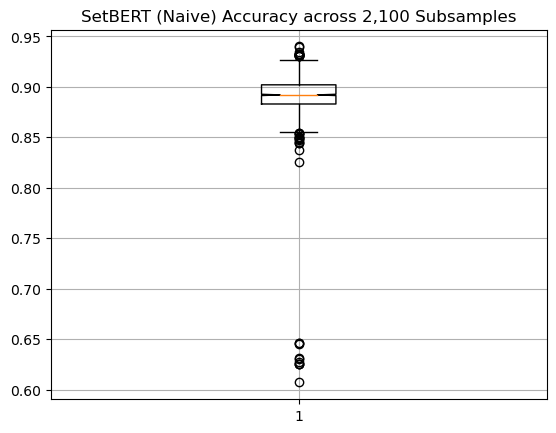

In [26]:
plt.boxplot(dataset_accuracies["Nachusa"], notch=True)
plt.title("SetBERT (Naive) Accuracy across 2,100 Subsamples")
plt.grid()

In [33]:
accuracy

[0.9022189378738403, 0.8069999814033508]

In [27]:
np.expand_dims(np.array([0, 0]), 0)

array([[0, 0]])

In [23]:
accuracies = []
for i, (sample_file, tax_file) in enumerate(zip(
    dataset.fastas(Dataset.Split.Train),
    dataset.taxonomies(Dataset.Split.Train)
)):
    print(f"\r{i+1}", end="")
    sequences = []
    taxonomies = []
    for sequence, tax in fasta.entries_with_taxonomy(fasta.entries(sample_file), taxonomy.entries(tax_file)):
        sequences.append(dna.encode_sequence(sequence.sequence))
        taxonomies.append(model.taxonomy_id_map.label_to_id(tax.label))
    sequences = np.expand_dims(np.array(sequences), 0)
    taxonomies = np.expand_dims(np.array(taxonomies), 0)
    sequences = dna.encode_kmers(sequences, 3)
    _, accuracy = model.evaluate(sequences, taxonomies, batch_size=1, verbose=False)
    accuracies.append(accuracy)

2100

In [35]:
accuracies = np.array(accuracies)

In [24]:
print("SetBERT (Naive with Backprop):")
print("Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):")
print("Metrics are computed across 2,100 subsamples.")
print(f"Min: {np.min(accuracies):%}")
print(f"Mean: {np.mean(accuracies):%}")
print(f"Max: {np.max(accuracies):%}")
print(f"STD: {np.std(accuracies):%}")

SetBERT (Naive with Backprop):
Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 62.400001%
Mean: 89.153048%
Max: 94.000000%
STD: 2.231637%


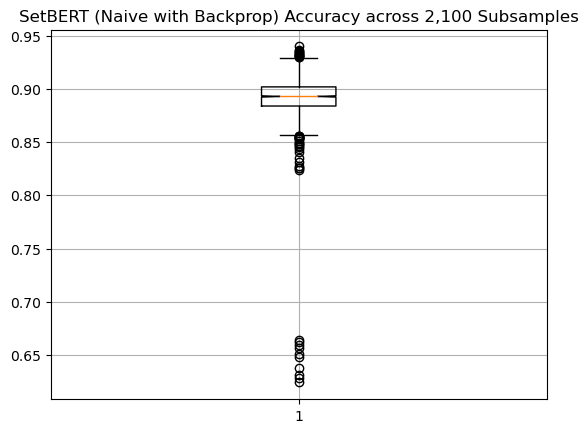

In [25]:
plt.boxplot(accuracies, notch=True)
plt.title("SetBERT (Naive with Backprop) Accuracy across 2,100 Subsamples")
plt.grid()

In [26]:
np.savetxt("./logs/setbert_taxonomy_naive_full_accuracy.txt", accuracies)

In [27]:
accuracies_dnabert = np.loadtxt("./logs/dnabert_taxonomy_naive_accuracy.txt")

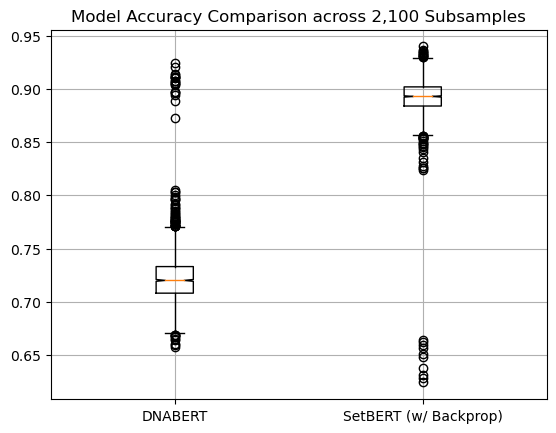

In [32]:
plt.boxplot([accuracies_dnabert, accuracies], notch=True, labels=["DNABERT", "SetBERT (w/ Backprop)"])
plt.title("Model Accuracy Comparison across 2,100 Subsamples")
plt.grid()

In [43]:
sample_files = list(dataset.fastas(Dataset.Split.Train))

In [44]:
accuracies[np.argsort(accuracies)[:20]]

array([0.62400001, 0.62800002, 0.63099998, 0.63800001, 0.648     ,
       0.65100002, 0.65600002, 0.65899998, 0.662     , 0.66399997,
       0.824     , 0.82599998, 0.82599998, 0.82800001, 0.83099997,
       0.83499998, 0.84100002, 0.84399998, 0.84500003, 0.84600002])

In [52]:
np.argsort(accuracies)[:10]

array([1162, 1165, 1164, 1160, 1166, 1167, 1168, 1161, 1169, 1163])

In [45]:
print(sample_files[0].name)

WS-AG-Apr2016_S85_L001_R1_001.001.fasta


In [53]:
print(sample_files[116].name)
print(np.mean(accuracies[1160:1160+10]))
print()

print(sample_files[151].name)
print(np.mean(accuracies[1510:1510 + 10]))
print()

print(sample_files[209].name)
print(np.mean(accuracies[2090:2090 + 10]))

WS-CCE-Sep2015_S60_L001_R1_001.007.fasta
0.646100002527237

WS-CCW-May2015_S49_L001_R1_001.002.fasta
0.8870000004768371

WS-FC-Jul2016_S94_L001_R1_001.010.fasta
0.898800003528595
